# NLP Model

- Create a basic nlp model to predict bin price
- Create a basic model using car info to predict bin price

In [60]:
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import re

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix


In [2]:
data = pd.read_csv('CleanData.csv')

In [3]:
data = data.drop(columns='Unnamed: 0')

In [4]:
data

,DriveTrain,Mileage,SalePrice,PriceCategory,CleanReviews,Year,newSize,newCyl,newMake,mpg
0,FWD,53200.0,29000.0,BelowAverage,Virtually nothing has gone wrong with my 2020 ...,2020.0,2.5,4,Toyota,27.0
1,RWD,22690.0,55975.0,Expensive,Stranded today. Could not get to work. Somethi...,2016.0,3.0,6,Volkswagen,18.0
2,FWD,17854.0,38900.0,AboveAverage,"Excellent road car, quiet, stable, comfortable...",2020.0,3.5,6,Other,18.0
3,FWD,60907.0,22125.0,BelowAverage,"PURCHASED FROM NYE TOYOTA, MY FIRST TACOMA. LO...",2021.0,2.5,4,Toyota,28.0
4,FWD,41614.0,23946.0,BelowAverage,I’ve own a 2020 Altima (under 30k miles) for a...,2020.0,2.4,4,Nissan,24.0
...,...,...,...,...,...,...,...,...,...,...
8469,FWD,78378.0,25500.0,BelowAverage,Only had the X5 for 4 weeks now but so far it ...,2022.0,3.6,6,BMW,18.0
8470,AWD,30909.0,35590.0,Average,When I bought my 2020 Tacoma V6 (3.5L) 4x4 in ...,2019.0,3.6,6,Toyota,18.0
8471,FWD,30186.0,24000.0,BelowAverage,Everything is great except the rear view camer...,2015.0,2.5,4,INFINITI,23.0
8472,FWD,22309.0,71077.0,Expensive,I have owned smaller SUV\s and Trucks for over...,2020.0,5.7,8,Toyota,15.0


**Review cleaning**
- make a base model for nlp

In [5]:
df = data[['CleanReviews', 'PriceCategory']]

In [6]:
df.head()

,CleanReviews,PriceCategory
0,Virtually nothing has gone wrong with my 2020 ...,BelowAverage
1,Stranded today. Could not get to work. Somethi...,Expensive
2,"Excellent road car, quiet, stable, comfortable...",AboveAverage
3,"PURCHASED FROM NYE TOYOTA, MY FIRST TACOMA. LO...",BelowAverage
4,I’ve own a 2020 Altima (under 30k miles) for a...,BelowAverage


In [7]:
rev_index = 100

In [8]:
df['CleanReviews'][rev_index]

'Hands down the best Jeep ever.. would take it over the Santa Fe any day of the week.. there’s no comparison.. performance is excellent.. have 70,000 miles on a 2018 and a 2019.. ac went out on one but warranty covered it🙂🙂, I absolutely love my jeep it’s comfortable reliable and completely rugged I never feel like I’m going to get stranded stuck or be taken down by anything you feel completely safe high up and well compact in this vehicle definitely worth the money I will never change my vehicle make!!! Jeep owner for GOOD!!! , have a 2019 high altitude , love this vehicle so comfortable and smooth love it, first vehicle i have loved driving. love the design and the smooth ride'

**Testing out the patter, make sure it's taking out the unwanted characters**

In [9]:
re.sub("[a-zA-Z]+(?:'[a-z]+)?", '', df['CleanReviews'][rev_index])

'     ..            .. ’  ..   ..  70,000    2018   2019..         🙂🙂,      ’          ’                                  !!!    !!! ,   2019   ,         ,      .       '

# Pre-proccessing

- just lowercase all the reviews, the tfidvectorizer will take care of the rest

In [10]:
df['CleanReviews'] = df['CleanReviews'].str.lower()

<ipython-input-10-f0607efd20df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CleanReviews'] = df['CleanReviews'].str.lower()


In [11]:
df.head()

,CleanReviews,PriceCategory
0,virtually nothing has gone wrong with my 2020 ...,BelowAverage
1,stranded today. could not get to work. somethi...,Expensive
2,"excellent road car, quiet, stable, comfortable...",AboveAverage
3,"purchased from nye toyota, my first tacoma. lo...",BelowAverage
4,i’ve own a 2020 altima (under 30k miles) for a...,BelowAverage


- clean up reviews, 

In [12]:
#stopwords
sw = stopwords.words('english')

# Train, Test,  Split

- Creating a holdout set to use at the very end

In [21]:
X = data['CleanReviews']
y = data['PriceCategory']

In [22]:
X_t, X_hold, y_t, y_hold = train_test_split(X, y, test_size=0.10, random_state=42)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.25, random_state=42)

# Vectorize

In [32]:
vectorizer = TfidfVectorizer(
    token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",
    stop_words=sw,
    max_df=.95,  # removes words that appear in more than 95% of docs
    min_df=2     # removes words that appear 2 or fewer times
)

In [33]:
X_train.iloc[rev_index]

'The ride is great, Toyota gives comfort and space, very good on gas and good price to own the car all you need is on this vehicle, This car rides nice and runs great it meets all of my driving needs. Would definitely buy another one. I needed a reliable car to get to work. Thank you, I went with the 2017 model due to the new 2018 + models having issues w/ that new 8 speed transmission. This was the last model w/  a bulletproof transmission so far. I hope to pay this car off and be payment free and problem free for the next decade. Always go with Toyota. They are the most reliable by statistics and no one wants to have car troubles.'

In [34]:
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train)
X_val_vec = vectorizer.transform(X_val)

In [35]:
X_train_vec.shape

(5719, 8314)

In [36]:
classifier = MultinomialNB()
classifier.fit(X_train_vec, y_train)
classifier.score(X_val_vec, y_val)

0.2270582066072365

# Features for the car

In [37]:
data.head()

,DriveTrain,Mileage,SalePrice,PriceCategory,CleanReviews,Year,newSize,newCyl,newMake,mpg
0,FWD,53200.0,29000.0,BelowAverage,Virtually nothing has gone wrong with my 2020 ...,2020.0,2.5,4,Toyota,27.0
1,RWD,22690.0,55975.0,Expensive,Stranded today. Could not get to work. Somethi...,2016.0,3.0,6,Volkswagen,18.0
2,FWD,17854.0,38900.0,AboveAverage,"Excellent road car, quiet, stable, comfortable...",2020.0,3.5,6,Other,18.0
3,FWD,60907.0,22125.0,BelowAverage,"PURCHASED FROM NYE TOYOTA, MY FIRST TACOMA. LO...",2021.0,2.5,4,Toyota,28.0
4,FWD,41614.0,23946.0,BelowAverage,I’ve own a 2020 Altima (under 30k miles) for a...,2020.0,2.4,4,Nissan,24.0


In [53]:
data['DriveTrain'].value_counts()

FWD    5281
AWD    1801
RWD    1392
Name: DriveTrain, dtype: int64

In [38]:
X = data.drop(columns=['CleanReviews', 'PriceCategory'])
y = data['PriceCategory']

In [39]:
X_t, X_hold, y_t, y_hold = train_test_split(X, y, test_size=0.10, random_state=42)

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.25, random_state=42)

In [44]:
num_cols = ['Mileage', 'SalePrice', 'Year', 'newSize', 'newCyl', 'mpg']
cat_cols = ['DriveTrain', 'newMake']

In [54]:
cat_transformer = OneHotEncoder(drop=['RWD', 'Other'])

In [55]:
num_transformer = MinMaxScaler()

In [56]:
preprocessor = ColumnTransformer(transformers=[
    ("num_trans", num_transformer, num_cols),
    ('cat_trans', cat_transformer, cat_cols)
])

In [57]:
preprocessor.fit_transform(X_train)

<5719x33 sparse matrix of type '<class 'numpy.float64'>'
	with 44506 stored elements in Compressed Sparse Row format>

In [61]:
clf_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [62]:
clf_knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans', MinMaxScaler(),
                                                  ['Mileage', 'SalePrice',
                                                   'Year', 'newSize', 'newCyl',
                                                   'mpg']),
                                                 ('cat_trans',
                                                  OneHotEncoder(drop=['RWD',
                                                                      'Other']),
                                                  ['DriveTrain', 'newMake'])])),
                ('knn', KNeighborsClassifier())])

In [63]:
print(f"Train Accuracy: {clf_knn.score(X_train, y_train)}")
print(f"Test Accuracy: {clf_knn.score(X_val, y_val)}")

Train Accuracy: 0.673719181675118
Test Accuracy: 0.5081279496591505


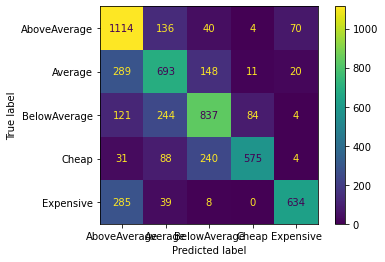

In [64]:
plot_confusion_matrix(clf_knn, X_train, y_train);

# Finding k's

In [65]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

k_scores_train = {}
k_scores_val = {}


for k in range(1, 20, 2):
    #knn = KNeighborsClassifier(n_neighbors=k)
    accuracy_score_t = []
    accuracy_score_v = []
    for train_ind, val_ind in kf.split(X_train, y_train):
        
        X_t, y_t = X_train.iloc[train_ind], y_train.iloc[train_ind] 
        X_v, y_v = X_train.iloc[val_ind], y_train.iloc[val_ind]
        
        y_pred_t = clf_knn.predict(X_t)
        y_pred_v = clf_knn.predict(X_v)
        
        accuracy_score_t.append(accuracy_score(y_t, y_pred_t))
        accuracy_score_v.append(accuracy_score(y_v, y_pred_v))
        
        
    k_scores_train[k] = np.mean(accuracy_score_t)
    k_scores_val[k] = np.mean(accuracy_score_v)


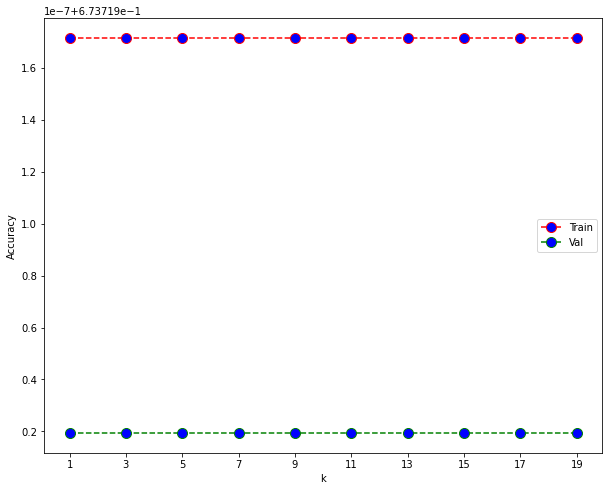

In [66]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(list(k_scores_train.keys()), list(k_scores_train.values()),
        color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10, label='Train')
ax.plot(list(k_scores_val.keys()), list(k_scores_val.values()),
        color='green', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10, label='Val')
ax.set_xlabel('k')
ax.set_ylabel('Accuracy')
ax.set_xticks(ticks=list(k_scores_val.keys()))
plt.legend();

# Stacking